In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import numpy as np
from sklearn.preprocessing import StandardScaler


In [13]:
data_path = '../../../dataset/Synthetic_CV_Dec.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}") # Pretty Amazing!

Mean Squared Error: 11.35


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x0000026EE51866F0>


Global SHAP Score:


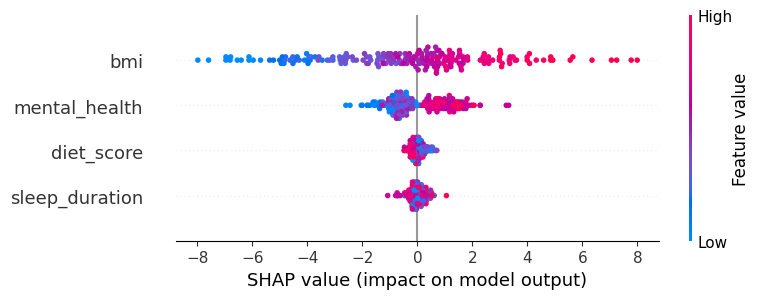

Index(['diet_score', 'sleep_duration', 'bmi', 'mental_health'], dtype='object')
Average values for each column:
Column 0: 0.1952
Column 1: 0.1945
Column 2: 2.3926
Column 3: 0.9062


In [15]:
# Tree SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

print("Global SHAP Score:")
shap.summary_plot(shap_values, X_test)

column_averages = np.mean(np.abs(shap_values), axis=0)

print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(8.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(6.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0
DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = np.float64(3.8986428091272654)
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 5.009804984536668
DEBUG:shap:self.fx = 16.008086451113822
DEBUG:

Global SHAP Score:


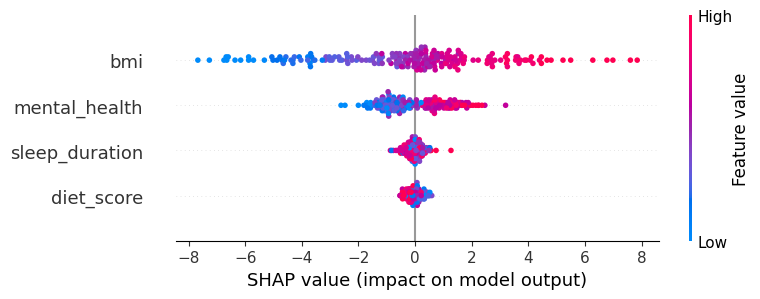

Index(['diet_score', 'sleep_duration', 'bmi', 'mental_health'], dtype='object')
Average values for each column:
Column 0: 0.1921
Column 1: 0.2050
Column 2: 2.2864
Column 3: 0.9642


In [16]:
# Kernel SHAP
background_data = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(rf.predict, background_data)
shap_values = explainer.shap_values(X_test)

print("Global SHAP Score:")
shap.summary_plot(shap_values, X_test)

column_averages = np.mean(np.abs(shap_values), axis=0)

print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x0000026EE51E8350>


Global SHAP Score:


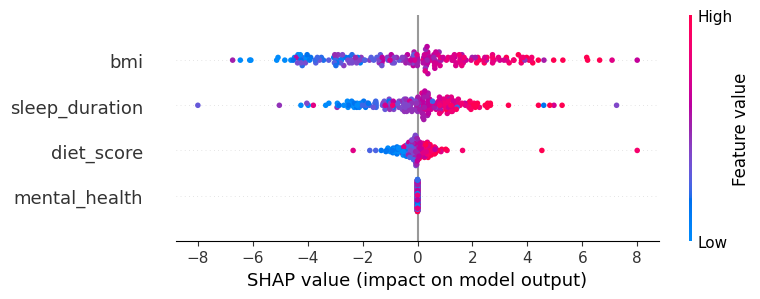

None
Index(['diet_score', 'sleep_duration', 'bmi', 'mental_health'], dtype='object')
Average values for each column:
Column 0: 0.4426
Column 1: 1.3368
Column 2: 2.2806
Column 3: 0.0000


In [24]:
# Causal SHAP
import pickle

file_path = '../../../result/R/Causal_SHAP_CV_42_Dec.pkl'
def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

# Usage
data_path = '../../../dataset/Synthetic_CV_Dec.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']
feature_names = X.columns.tolist()

causal_shap_values = load_and_format_shap_values(file_path, feature_names)
causal_shap_values = np.clip(causal_shap_values, -8, 8)  

print("Global SHAP Score:")
print(shap.summary_plot(causal_shap_values, X_test))

column_averages = np.mean(np.abs(causal_shap_values), axis=0)
print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

In [123]:
import pickle

file_path = '../../../result/SyntheticCV/Causal_SHAP_CV_42.pkl'

# Load the data
with open(file_path, 'rb') as f:
    phi_normalized_list = pickle.load(f)

sums = {}
counts = {}

for instance in phi_normalized_list:
    for feature, value in instance.items():
        sums[feature] = sums.get(feature, 0) + abs(value)
        counts[feature] = counts.get(feature, 0) + 1

means = {feature: sums[feature] / counts[feature] for feature in sums}

sorted_means = sorted(means.items(), key=lambda item: abs(item[1]), reverse=True)

causal_output_list = [(feature, mean_value) for feature, mean_value in sorted_means]

print(causal_output_list)


[('age', np.float64(1.3400069750143317)), ('bmi', np.float64(0.2504178918001364)), ('fitness', np.float64(0.23045080737843127)), ('diet_score', np.float64(0.06974439872310584)), ('exercise_level', np.float64(0.06697237590352084))]


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x0000014E7B2B9580>


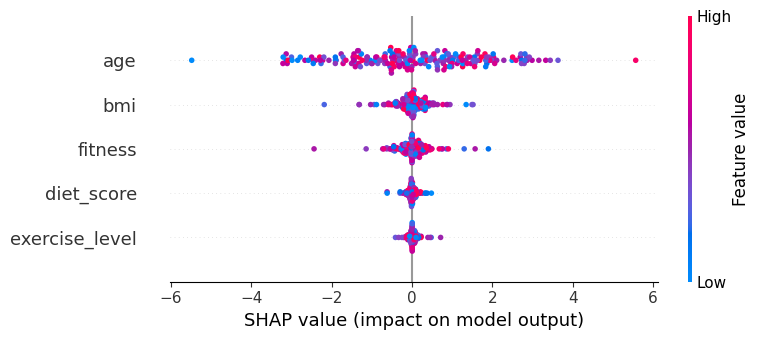

Average values for each column:
Column 0: 1.3400
Column 1: 0.0697
Column 2: 0.0670
Column 3: 0.2504
Column 4: 0.2305


In [124]:
phi_normalized_df = pd.DataFrame(phi_normalized_list)
phi_normalized_df = phi_normalized_df[X_test.columns]

shap.summary_plot(phi_normalized_df.values, X_test)

column_averages = np.mean(np.abs(phi_normalized_df.values), axis=0)

print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

In [125]:
data_path = '../../../dataset/Synthetic_CV.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk','bmi','fitness'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}") # Pretty Amazing!

Mean Squared Error: 0.86


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x0000014E6FE1CE90>


Global SHAP Score:


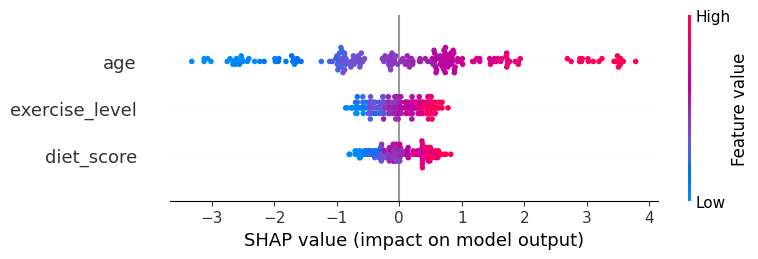

Average values for each column:
Column 0: 1.3060
Column 1: 0.3239
Column 2: 0.3334


In [126]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

print("Global SHAP Score:")
shap.summary_plot(shap_values, X_test)

column_averages = np.mean(np.abs(shap_values), axis=0)

print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

## With the Causal Pickle files

1. Average the causal values across all five outputs
2. Compare it with SHAP (All features) and Exact SHAP (Only subset of features)
3. Think of an explanatioin for the working of my evaluation

#### Exact SHAP

In [135]:
X = df.drop(columns=['cv_risk','bmi','fitness'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

explainer = shap.ExactExplainer(rf.predict, X_test)
exact_reduced_shap_values = explainer(X_test[:])

ExactExplainer explainer: 201it [00:18,  4.91it/s]                         


#### Kernel SHAP

In [137]:
X = df.drop(columns=['cv_risk'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

background_data = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(rf.predict, background_data)
kernel_shap_values = explainer.shap_values(X_test)

100%|██████████| 200/200 [00:22<00:00,  9.08it/s]


#### TreeSHAP

In [154]:
X = df.drop(columns=['cv_risk'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf)
tree_shap_values = explainer.shap_values(X_test)

#### Causal SHAP

In [150]:
def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

causal_shap_values = load_and_format_shap_values('../../../result/SyntheticCV/Causal_SHAP_CV_456.pkl', X.columns.tolist())

#### Eval

In [156]:
def evaluate_global_rmse_synthetic(full_shap_values, reduced_shap_values, feature_subset_list):
    """
    Evaluate SHAP values by comparing attributions with and without intermediary features.
    """
    feature_indices = [list(X_test.columns).index(f) for f in feature_subset_list]
    
    if isinstance(full_shap_values, list):
        full_importance = pd.Series({
            feature: np.abs(full_shap_values[:, idx]).mean() 
            for feature, idx in zip(feature_subset_list, feature_indices)
        })
    else:
        full_values = full_shap_values[:, feature_indices]
        full_importance = pd.Series(
            np.abs(full_values).mean(axis=0),
            index=feature_subset_list
        )
    
    if hasattr(reduced_shap_values, 'values'):
        reduced_values = reduced_shap_values.values
    else:
        reduced_values = reduced_shap_values
        
    if isinstance(reduced_values, list):
        reduced_importance = pd.Series({
            feature: np.abs(reduced_values[:, idx]).mean() 
            for feature, idx in zip(feature_subset_list, feature_indices)
        })
    else:
        reduced_values = reduced_values[:, feature_indices]
        reduced_importance = pd.Series(
            np.abs(reduced_values).mean(axis=0),
            index=feature_subset_list
        )
    
    squared_diff_sum = 0
    for feature in feature_subset_list:
        squared_diff_sum += (full_importance[feature] - reduced_importance[feature]) ** 2
    
    rmse = np.sqrt(squared_diff_sum / len(feature_subset_list))
    
    return rmse

feature_subset = ['age', 'diet_score', 'exercise_level']

rmse_kernel = evaluate_global_rmse_synthetic(
    kernel_shap_values,
    exact_reduced_shap_values,
    feature_subset
)

rmse_tree = evaluate_global_rmse_synthetic(
    tree_shap_values,
    exact_reduced_shap_values,
    feature_subset
)

rmse_causal = evaluate_global_rmse_synthetic(
    causal_shap_values,
    exact_reduced_shap_values,
    feature_subset
)

print(f"Kernel SHAP RMSE: {rmse_kernel}")
print(f"Tree SHAP RMSE: {rmse_tree}")
print(f"Causal SHAP RMSE: {rmse_causal}")

Kernel SHAP RMSE: 0.3905959751120137
Tree SHAP RMSE: 0.3009616583508997
Causal SHAP RMSE: 0.20925183654310342


### Eval Everything Together

In [157]:
def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

def evaluate_global_rmse_synthetic(full_shap_values, reduced_shap_values, feature_subset_list):
    """
    Evaluate SHAP values by comparing attributions with and without intermediary features.
    """
    feature_indices = [list(X_test.columns).index(f) for f in feature_subset_list]
    
    if isinstance(full_shap_values, list):
        full_importance = pd.Series({
            feature: np.abs(full_shap_values[:, idx]).mean() 
            for feature, idx in zip(feature_subset_list, feature_indices)
        })
    else:
        full_values = full_shap_values[:, feature_indices]
        full_importance = pd.Series(
            np.abs(full_values).mean(axis=0),
            index=feature_subset_list
        )
    
    if hasattr(reduced_shap_values, 'values'):
        reduced_values = reduced_shap_values.values
    else:
        reduced_values = reduced_shap_values
        
    if isinstance(reduced_values, list):
        reduced_importance = pd.Series({
            feature: np.abs(reduced_values[:, idx]).mean() 
            for feature, idx in zip(feature_subset_list, feature_indices)
        })
    else:
        reduced_values = reduced_values[:, feature_indices]
        reduced_importance = pd.Series(
            np.abs(reduced_values).mean(axis=0),
            index=feature_subset_list
        )
    
    squared_diff_sum = 0
    for feature in feature_subset_list:
        squared_diff_sum += (full_importance[feature] - reduced_importance[feature]) ** 2
    
    rmse = np.sqrt(squared_diff_sum / len(feature_subset_list))
    
    return rmse

In [176]:
seeds = [42, 123, 456, 789, 1010]
results = {
    'kernel': [],
    'tree': [],
    'causal': []
}

for seed in seeds:
    print(f"\nProcessing seed: {seed}")
    
    # Exact SHAP
    X = df.drop(columns=['cv_risk','bmi','fitness'])
    y = df['cv_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    explainer = shap.ExactExplainer(rf.predict, X_test)
    exact_reduced_shap_values = explainer(X_test[:])

    # Kernel SHAP
    X = df.drop(columns=['cv_risk'])
    y = df['cv_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    rf.fit(X_train, y_train)

    background_data = shap.kmeans(X_train, 100)
    explainer = shap.KernelExplainer(rf.predict, background_data)
    kernel_shap_values = explainer.shap_values(X_test)

    # Tree SHAP
    explainer = shap.TreeExplainer(rf)
    tree_shap_values = explainer.shap_values(X_test)

    # Causal SHAP
    causal_shap_values = load_and_format_shap_values(
        f'../../../result/SyntheticCV/Causal_SHAP_CV_{seed}.pkl', 
        X.columns.tolist()
    )

    # Evaluation
    feature_subset = ['age', 'diet_score', 'exercise_level']

    rmse_kernel = evaluate_global_rmse_synthetic(
        kernel_shap_values,
        exact_reduced_shap_values,
        feature_subset
    )

    rmse_tree = evaluate_global_rmse_synthetic(
        tree_shap_values,
        exact_reduced_shap_values,
        feature_subset
    )

    rmse_causal = evaluate_global_rmse_synthetic(
        causal_shap_values,
        exact_reduced_shap_values,
        feature_subset
    )

    # Store results
    results['kernel'].append(rmse_kernel)
    results['tree'].append(rmse_tree)
    results['causal'].append(rmse_causal)
    
    print(f"Seed {seed} Results:")
    print(f"Kernel SHAP RMSE: {rmse_kernel:.4f}")
    print(f"Tree SHAP RMSE: {rmse_tree:.4f}")
    print(f"Causal SHAP RMSE: {rmse_causal:.4f}")

# Calculate and print means and standard deviations
print("\nFinal Results:")
for method in results:
    mean_rmse = np.mean(results[method])
    std_rmse = np.std(results[method])
    print(f"{method.capitalize()} SHAP - Mean RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")


Processing seed: 42


ExactExplainer explainer: 201it [00:17,  5.02it/s]                         
100%|██████████| 200/200 [00:21<00:00,  9.26it/s]


Seed 42 Results:
Kernel SHAP RMSE: 0.4491
Tree SHAP RMSE: 0.3437
Causal SHAP RMSE: 0.2371

Processing seed: 123


ExactExplainer explainer: 201it [00:17,  4.81it/s]                         
100%|██████████| 200/200 [00:22<00:00,  9.02it/s]


Seed 123 Results:
Kernel SHAP RMSE: 0.4152
Tree SHAP RMSE: 0.3264
Causal SHAP RMSE: 0.2204

Processing seed: 456


ExactExplainer explainer: 201it [00:17,  4.91it/s]                         
100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Seed 456 Results:
Kernel SHAP RMSE: 0.3906
Tree SHAP RMSE: 0.3010
Causal SHAP RMSE: 0.2093

Processing seed: 789


ExactExplainer explainer: 201it [00:17,  5.01it/s]                         
100%|██████████| 200/200 [00:22<00:00,  9.01it/s]


Seed 789 Results:
Kernel SHAP RMSE: 0.4401
Tree SHAP RMSE: 0.3382
Causal SHAP RMSE: 0.2164

Processing seed: 1010


ExactExplainer explainer: 201it [00:18,  4.90it/s]                         
100%|██████████| 200/200 [00:21<00:00,  9.22it/s]


Seed 1010 Results:
Kernel SHAP RMSE: 0.3912
Tree SHAP RMSE: 0.2972
Causal SHAP RMSE: 0.3768

Final Results:
Kernel SHAP - Mean RMSE: 0.4172 ± 0.0242
Tree SHAP - Mean RMSE: 0.3213 ± 0.0190
Causal SHAP - Mean RMSE: 0.2520 ± 0.0631


### Synthetic CV Kernel SHAP Experiment

In [3]:
from evaluation import evaluate_global_shap_scores

data_path = '../../../dataset/Synthetic_CV.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']
feature_names = X.columns.tolist()

seeds = [42, 123, 456, 789, 1010]
# Rerun 42, 123
all_scores = {
    'deletion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    },
    'insertion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")

    X = df.drop(columns=['cv_risk'])
    y = df['cv_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    rf.fit(X_train, y_train)

    background_data = shap.kmeans(X_train, 100)
    explainer = shap.KernelExplainer(rf.predict, background_data)
    kernel_shap_values = explainer.shap_values(X_test)

    result = evaluate_global_shap_scores(rf, X_test, y_test, pd.Series(np.abs(kernel_shap_values).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['rmse', 'mae', 'r_squared']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1

Training Random Forest model...


  0%|          | 0/200 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.6, 0.4])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 2
DEBUG:shap:self.M = 5
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(10.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 18.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.8000000000000003
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(20.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 20.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0000000000000002
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0
DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0., -1.,  0.,  0.]])
DEBUG:shap:np.sum(w) = np.float64(-0.925662165806692)
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -1.0840790333123986
DEBUG:

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2614594309544733,
                3.822660233446925,
                4.899486047625211,
                4.8333422443764995,
                4.838411681553077
            ],
            "mae": [
                1.893067314317297,
                3.4275060846738428,
                4.481429799870138,
                4.410164072579015,
                4.4137666413000405
            ],
            "r_squared": [
                -0.30001472703890997,
                -2.7145145779837905,
                -5.101993213355224,
                -4.93834966255159,
                -4.950813037300809
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.131071927591237,
            "mae": 3.7251867825480667,
            "r_sq

  0%|          | 0/200 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.6, 0.4])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 2
DEBUG:shap:self.M = 5
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(10.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 18.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.8000000000000003
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(20.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 20.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0000000000000002
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0
DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0., -1.,  0.,  0.]])
DEBUG:shap:np.sum(w) = np.float64(0.4890383411636561)
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 1.5900708020350836
DEBUG:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2233366688867293,
                4.055765018932721,
                4.927060817125365,
                4.914983562076735,
                4.850222210456739
            ],
            "mae": [
                1.9005863106694665,
                3.648285277346726,
                4.4848501533873115,
                4.472353940368213,
                4.406825481566784
            ],
            "r_squared": [
                -0.1969897234327691,
                -2.983139626117036,
                -4.878354950892557,
                -4.849572119261548,
                -4.696436131639088
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.194273655495658,
            "mae": 3.7825802326677,
            "r_squared

  0%|          | 0/200 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.6, 0.4])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 2
DEBUG:shap:self.M = 5
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(10.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 18.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.8000000000000003
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(20.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 20.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0000000000000002
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0
DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0., -1.,  0.,  0.]])
DEBUG:shap:np.sum(w) = np.float64(2.49753167554578)
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 3.270162955325658
DEBUG:shap

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.377841687331674,
                3.9091266575808574,
                4.929846289155209,
                4.826809744609791,
                4.829281612796557
            ],
            "mae": [
                2.0344598787308086,
                3.5707618950731264,
                4.550186376065261,
                4.444762275152772,
                4.445847006319107
            ],
            "r_squared": [
                -0.5745786251124627,
                -3.2555721917995424,
                -5.768076126915886,
                -5.488119496037759,
                -5.494766487982111
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.174581198294818,
            "mae": 3.8092034862682147,
            "r_squ

  0%|          | 0/200 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.6, 0.4])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 2
DEBUG:shap:self.M = 5
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(10.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 18.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.8000000000000003
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(20.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 20.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0000000000000002
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0
DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0., -1.,  0.,  0.]])
DEBUG:shap:np.sum(w) = np.float64(1.3341267763316949)
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 1.9224669660721772
DEBUG:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.553524360979084,
                4.288538692928775,
                5.012434960275618,
                5.006512459659345,
                4.995943690183918
            ],
            "mae": [
                2.154250481110602,
                3.8593910559376186,
                4.59640183986064,
                4.589230902509008,
                4.579011340664107
            ],
            "r_squared": [
                -0.6320290978469485,
                -3.6032710985176344,
                -5.288475707220934,
                -5.2736240437874295,
                -5.247164706155024
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.371390832805348,
            "mae": 3.955657124016395,
            "r_square

  0%|          | 0/200 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.6, 0.4])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 2
DEBUG:shap:self.M = 5
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(10.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 18.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.8000000000000003
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(20.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 20.000000000000004
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0000000000000002
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0
DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0., -1.,  0.,  0.]])
DEBUG:shap:np.sum(w) = np.float64(1.094311990370694)
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 2.383830356916046
DEBUG:sha

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2666640960176054,
                4.075629174843361,
                4.7998003340877045,
                4.761060014990347,
                4.745867815525025
            ],
            "mae": [
                1.9386553172572565,
                3.7161277871414837,
                4.432302829571102,
                4.3932835967092805,
                4.376820411188423
            ],
            "r_squared": [
                -0.5170878978325575,
                -3.9048500847051697,
                -5.802722513776813,
                -5.693352924466648,
                -5.650705062498923
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.129804287092808,
            "mae": 3.771437988373509,
            "r_sq

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "rmse": {
            "mean": 4.200224380255975,
            "std": 0.08914257076757522
        },
        "mae": {
            "mean": 3.8088131227747772,
            "std": 0.07828376978518807
        },
        "r_squared": {
            "mean": -3.9121829533691668,
            "std": 0.3040042644243857
        }
    },
    "insertion": {
        "rmse": {
            "mean": 1.0149310233202695,
            "std": 0.030985049806410817
        },
        "mae": {
            "mean": 0.8761313150318628,
            "std": 0.02927066565191642
        },
        "r_squared": {
            "mean": 0.49700235370018114,
            "std": 0.043952904956183085
        }
    }
}


### Synthetic CV Tree SHAP Experiment

In [5]:
from evaluation import evaluate_global_shap_scores

data_path = '../../../dataset/Synthetic_CV.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']
feature_names = X.columns.tolist()

seeds = [42, 123, 456, 789, 1010]
# Rerun 42, 123
all_scores = {
    'deletion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    },
    'insertion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")

    X = df.drop(columns=['cv_risk'])
    y = df['cv_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    rf.fit(X_train, y_train)

    explainer = shap.TreeExplainer(rf)
    tree_shap_values = explainer.shap_values(X_test)

    result = evaluate_global_shap_scores(rf, X_test, y_test, pd.Series(np.abs(tree_shap_values).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['rmse', 'mae', 'r_squared']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1

Training Random Forest model...


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2614594309544733,
                3.8226602334469244,
                4.899486047625211,
                4.8333422443764995,
                4.838411681553077
            ],
            "mae": [
                1.893067314317297,
                3.4275060846738423,
                4.481429799870138,
                4.410164072579015,
                4.4137666413000405
            ],
            "r_squared": [
                -0.30001472703890997,
                -2.7145145779837896,
                -5.1019932133552235,
                -4.93834966255159,
                -4.950813037300809
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.131071927591237,
            "mae": 3.7251867825480667,
            "r_

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2233366688867293,
                4.055765018932722,
                4.927060817125365,
                4.914983562076735,
                4.85022221045674
            ],
            "mae": [
                1.9005863106694665,
                3.6482852773467265,
                4.4848501533873115,
                4.472353940368212,
                4.406825481566785
            ],
            "r_squared": [
                -0.1969897234327691,
                -2.9831396261170364,
                -4.878354950892557,
                -4.849572119261547,
                -4.69643613163909
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.194273655495659,
            "mae": 3.7825802326677,
            "r_squared

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.377841687331674,
                3.9091266575808574,
                4.9298462891552095,
                4.826809744609791,
                4.8292816127965565
            ],
            "mae": [
                2.0344598787308086,
                3.5707618950731264,
                4.5501863760652626,
                4.444762275152772,
                4.445847006319106
            ],
            "r_squared": [
                -0.5745786251124627,
                -3.2555721917995424,
                -5.768076126915888,
                -5.48811949603776,
                -5.494766487982108
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.174581198294818,
            "mae": 3.8092034862682147,
            "r_s

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.553524360979084,
                4.288538692928775,
                5.012434960275618,
                5.006512459659345,
                4.995943690183918
            ],
            "mae": [
                2.1542504811106014,
                3.8593910559376186,
                4.59640183986064,
                4.589230902509007,
                4.579011340664107
            ],
            "r_squared": [
                -0.6320290978469485,
                -3.603271098517636,
                -5.288475707220934,
                -5.2736240437874295,
                -5.247164706155024
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.371390832805348,
            "mae": 3.955657124016395,
            "r_square

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2666640960176054,
                4.07562917484336,
                4.7998003340877045,
                4.7919422860151855,
                4.745867815525026
            ],
            "mae": [
                1.9386553172572567,
                3.7161277871414824,
                4.432302829571102,
                4.422206302465364,
                4.376820411188424
            ],
            "r_squared": [
                -0.5170878978325575,
                -3.904850084705169,
                -5.802722513776813,
                -5.780466436994598,
                -5.6507050624989255
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.135980741297776,
            "mae": 3.777222529524726,
            "r_squ

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "rmse": {
            "mean": 4.201459671096968,
            "std": 0.08819593587397766
        },
        "mae": {
            "mean": 3.80997003100502,
            "std": 0.07776389366024945
        },
        "r_squared": {
            "mean": -3.915667493870285,
            "std": 0.3086513732765688
        }
    },
    "insertion": {
        "rmse": {
            "mean": 1.0150977326860162,
            "std": 0.031022783702434397
        },
        "mae": {
            "mean": 0.8762518983810477,
            "std": 0.029307167510145612
        },
        "r_squared": {
            "mean": 0.4969724350104771,
            "std": 0.044002101652544506
        }
    }
}


### Synthetic CV Causal SHAP Experiment

In [3]:
import pickle

file_paths = ['../../../result/SyntheticCV/Causal_SHAP_CV_42.pkl', '../../../result/SyntheticCV/Causal_SHAP_CV_123.pkl', '../../../result/SyntheticCV/Causal_SHAP_CV_456.pkl', '../../../result/SyntheticCV/Causal_SHAP_CV_789.pkl', '../../../result/SyntheticCV/Causal_SHAP_CV_1010.pkl']

def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

# Usage
data_path = '../../../dataset/Synthetic_CV.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']
feature_names = X.columns.tolist()
causal_shap_values = []

for file_path in file_paths:
    formatted_values = load_and_format_shap_values(file_path, feature_names)
    causal_shap_values.append(formatted_values)

In [5]:
from evaluation import evaluate_global_shap_scores

seeds = [42, 123, 456, 789, 1010]
# Rerun 42, 123
all_scores = {
    'deletion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    },
    'insertion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")

    X = df.drop(columns=['cv_risk'])
    y = df['cv_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    rf.fit(X_train, y_train)

    result = evaluate_global_shap_scores(rf, X_test, y_test, pd.Series(np.abs(causal_shap_values[idx]).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['rmse', 'mae', 'r_squared']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1

Training Random Forest model...


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2614594309544733,
                3.8226602334469253,
                4.899486047625211,
                4.908514211015364,
                4.838411681553077
            ],
            "mae": [
                1.893067314317297,
                3.4275060846738428,
                4.481429799870138,
                4.489225884651057,
                4.4137666413000405
            ],
            "r_squared": [
                -0.30001472703890997,
                -2.7145145779837914,
                -5.1019932133552235,
                -5.1245019203940005,
                -4.950813037300809
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.14610632091901,
            "mae": 3.740999144962475,
            "r_s

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.2233366688867293,
                3.7670502833503305,
                4.927060817125365,
                4.914983562076735,
                4.8502222104567405
            ],
            "mae": [
                1.9005863106694665,
                3.3869403639538813,
                4.484850153387312,
                4.472353940368213,
                4.406825481566787
            ],
            "r_squared": [
                -0.1969897234327691,
                -2.4362345085994024,
                -4.878354950892558,
                -4.849572119261548,
                -4.696436131639093
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.136530708379181,
            "mae": 3.730311249989132,
            "r_sq

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.377841687331674,
                4.211603704381524,
                4.92984628915521,
                4.826809744609791,
                4.829281612796557
            ],
            "mae": [
                2.0344598787308086,
                3.8387189069363252,
                4.5501863760652626,
                4.444762275152772,
                4.445847006319107
            ],
            "r_squared": [
                -0.5745786251124627,
                -3.939619271305726,
                -5.768076126915889,
                -5.48811949603776,
                -5.494766487982111
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.2350766076549515,
            "mae": 3.8627948886408547,
            "r_squar

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                2.553524360979084,
                3.805301893707314,
                5.012434960275618,
                5.006512459659346,
                4.995943690183918
            ],
            "mae": [
                2.154250481110602,
                3.432949667120031,
                4.596401839860639,
                4.589230902509008,
                4.579011340664107
            ],
            "r_squared": [
                -0.6320290978469485,
                -2.624316541769211,
                -5.288475707220934,
                -5.273624043787432,
                -5.247164706155024
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 4.274743472961055,
            "mae": 3.8703688462528776,
            "r_squared

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "rmse": {
            "mean": 4.185687570242395,
            "std": 0.05800702032606568
        },
        "mae": {
            "mean": 3.7963393318740124,
            "std": 0.059471684087847546
        },
        "r_squared": {
            "mean": -3.889441080393587,
            "std": 0.3534382890207578
        }
    },
    "insertion": {
        "rmse": {
            "mean": 1.0126128001902512,
            "std": 0.03573867962696723
        },
        "mae": {
            "mean": 0.8748151966505034,
            "std": 0.033521775252356306
        },
        "r_squared": {
            "mean": 0.49881771095302546,
            "std": 0.0465172791450196
        }
    }
}
